#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Знакомство с данными

Импортируем библиотеки

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



from catboost import CatBoostRegressor

import lightgbm as lgb

RANDOM_STATE = 333

Загрузим данные

In [2]:
data = pd.read_csv('taxi.csv')

Выведем первые 5 строк датафрейма

In [3]:
data.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Выведем информацию по нашему датафрейму

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


* Пропусков в данных нет
* Нужно изменить типы данных

Проверим количество дубликатов 

In [5]:
data.duplicated().sum()

0

Проверим количество дубликатов по колонке **datetime**

In [6]:
data.duplicated(subset=['datetime']).sum()

0

Дубликатов в данных нет

Посмотрим на распределение целевого признака **num_orders**

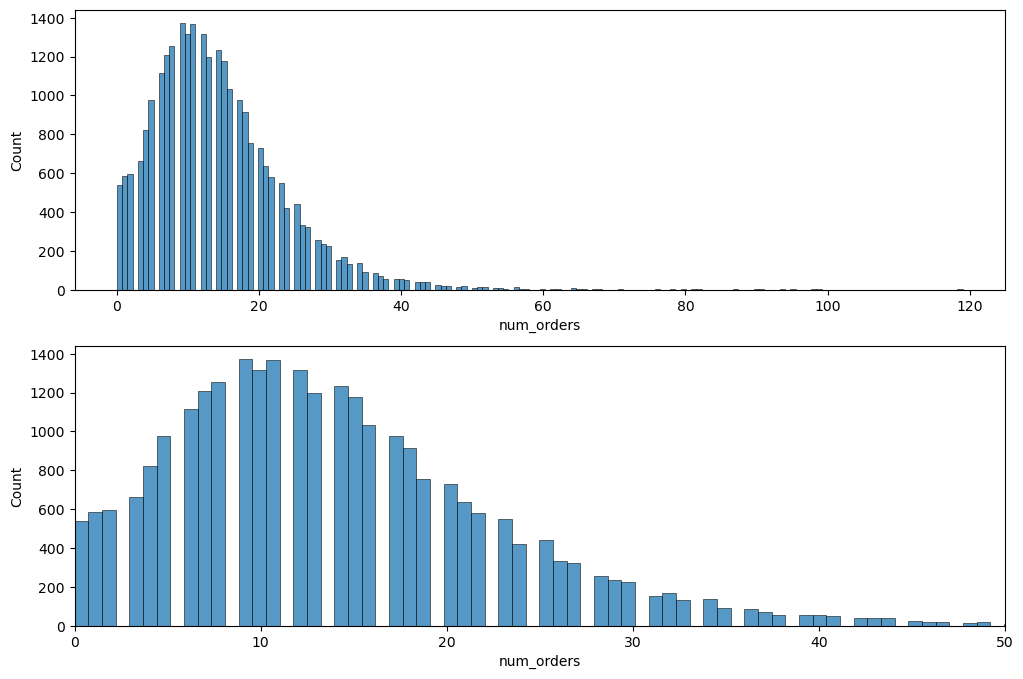

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.histplot(data['num_orders'], ax=ax[0]);
sns.histplot(data['num_orders'], ax=ax[1]).set(xlim = (0,50));

Целевая переменная принимает обычное распределение Пуассона, которое представляет собой число событий, произошедших за фиксированное время, при условии, что эти события происходят с некоторой фиксированной средней интенсивностью и независимо друг от друга.

### Вывод
* Загрузили нужные нам для работы библиотеки
* Загрузили и сохранили данные в датафрейм **df**
* Пропусков в данных нет
* Нужно изменить типы данных
* Дубликатов как явных, так и неявных в данных нет
* Целевая переменная принимает распределение Пуассона, что ей должно быть и свойственно 

## Предобработка

### Изменим типы данных

Посмотрим на типы данных и информацию о нашем датафрейме

In [8]:
display(data.dtypes)
data.describe()

datetime      object
num_orders     int64
dtype: object

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Мы можем изменить тип данных в:
* **datetime** object -> datetime
* **num_orders** int64 -> uint16

In [9]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['num_orders'] = data['num_orders'].astype('uint16')

Посмотрим на типы данных, после их измененния 

In [10]:
data.dtypes

datetime      datetime64[ns]
num_orders            uint16
dtype: object

Мы успешно изменили типы данных

### Ресемплирование

Чтобы проресемплировать данные по одному часу, нужно выставить столбец datetime как индекс

In [11]:
data = data.set_index('datetime')
data.sort_index(inplace=True)
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


проресемплируем данные по одному часу

In [12]:
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Создадим новые столбцы из datetime 

Напишем функцию для создания столбцов:
* **year** - год заказа
* **month** - месяц заказа
* **day** - день заказа
* **day_of_week** - день недели заказа
* **lag_N** - данные за N часов назад, создадим 24 столбца, так как нам интересны данные за 24 часа
* **rolling_mean** - Скользящее среднее за 25 часов

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [15]:
df = make_features(data, 24, 25)

In [16]:
df

,num_orders,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,165.36
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.72
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,167.00


Посмотрим сколько строк имеют пропуски 

In [17]:
df.isna().sum().max()

25

Всего 5 строк имеют пропуски, можно отбросить эти строчки

In [18]:
df.dropna(inplace=True)

### Выбросы в данных

In [19]:
def show_hists_box(data, data_label, num_bins, rug=False, log_scale=False):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title("Плотность распределения " + data_label, fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, ax=axes[0])
    axes[1].set_title("Boxplot " + data_label, fontsize=18)
    sns.boxplot(data=df, x=data_label, ax=axes[1])
    plt.show()

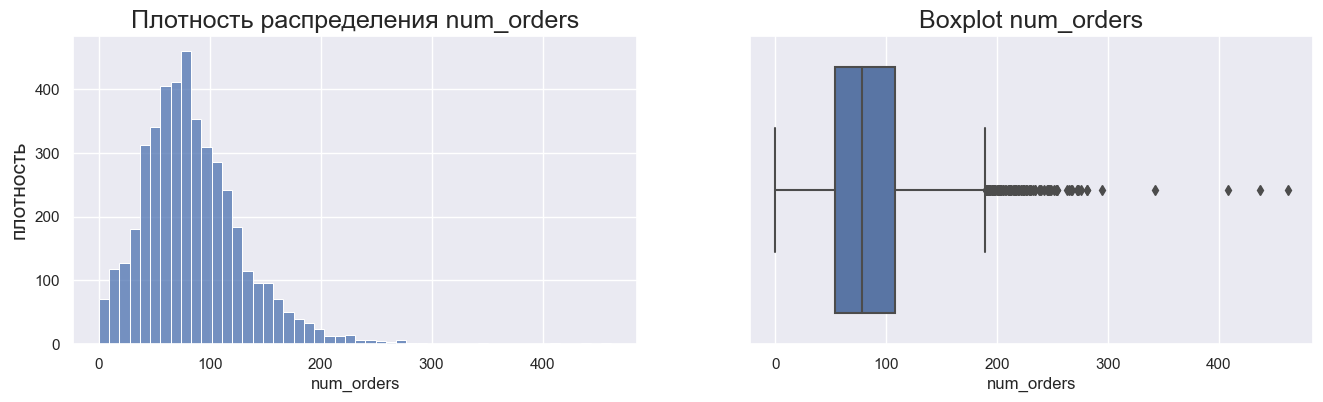

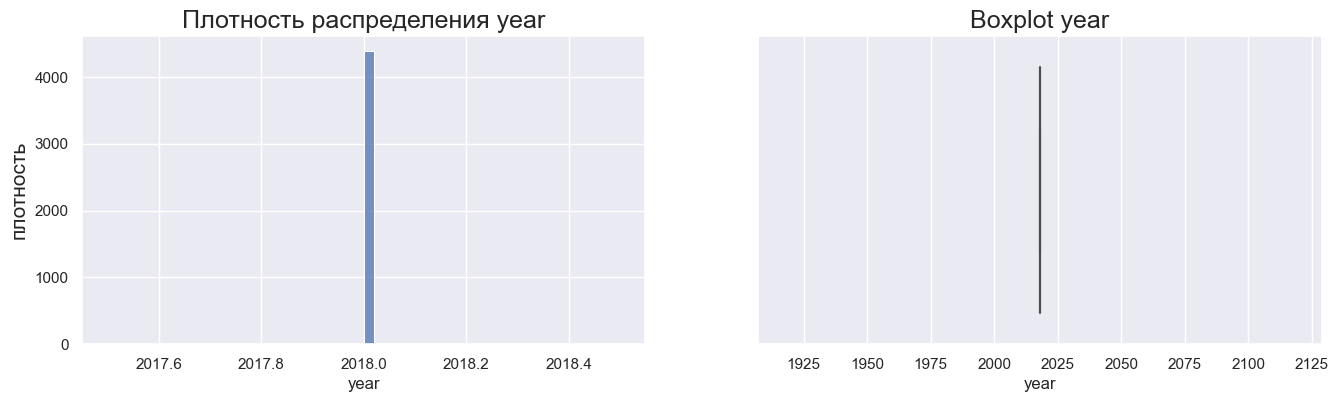

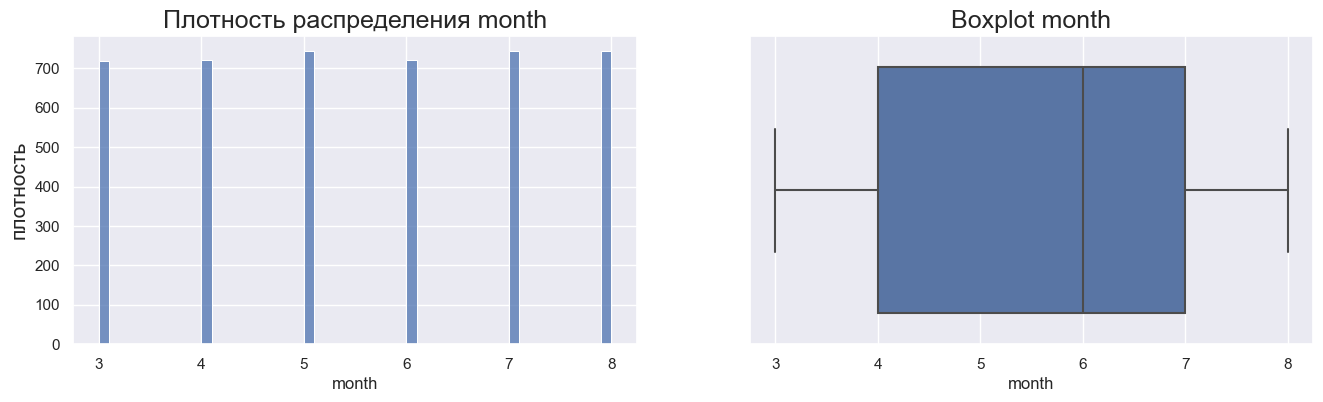

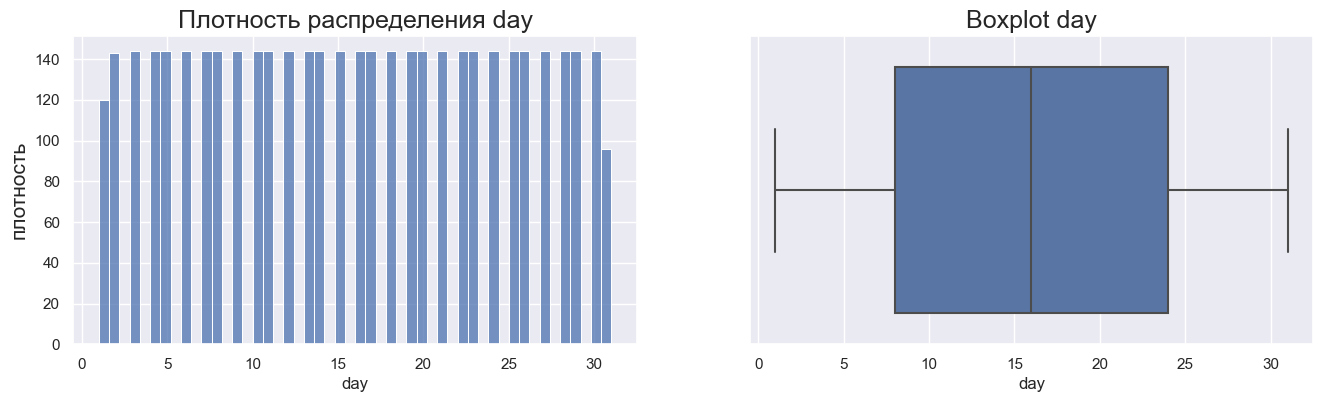

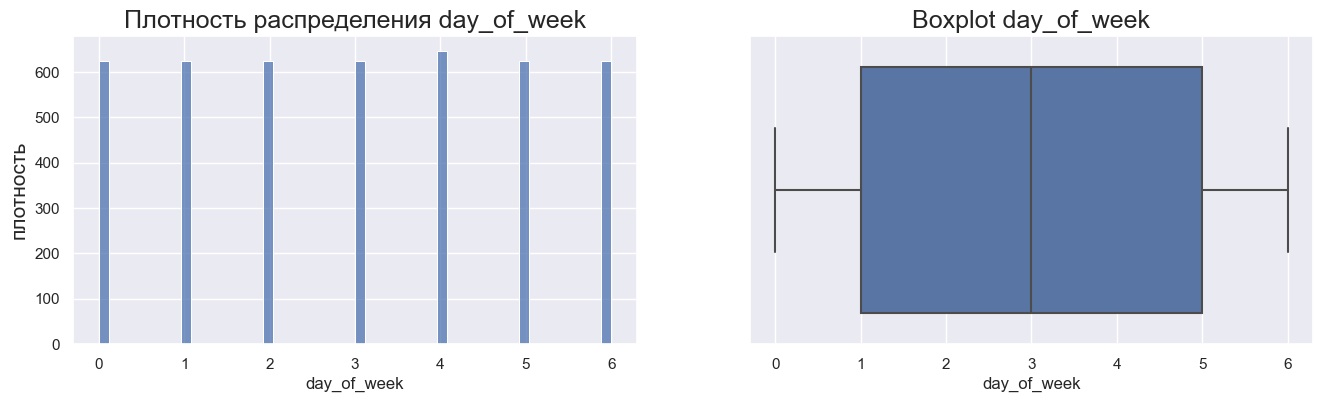

In [20]:
numerics = ['num_orders', 'year', 'month', 'day', 'day_of_week']
for column in numerics:
    show_hists_box(df[column], column, num_bins=50)

* Нам представлены данные за 3 месяца 2018 год
* Удалим переменную год так как она будет мешать работе модели
* Распределение целевой переменной соответствует распределению Пуассона

Посмотрим на выбросы целевого признака **num_orders**, для этого напишем функцию **number_of_emissions**

In [21]:
def number_of_emissions(data,col, multiplier=1.5, keep='all', details=False):
    rate_min = 0
    rate_max = 0
    if keep == 'all':
        score_max = (data[col].quantile(0.75) - data[col].quantile(0.25))*multiplier + data[col].quantile(0.75)
        rate_max = round(len(data.loc[data[col] > score_max]) / len(data) * 100, 2)

        score_min = data[col].quantile(0.25) - \
                (data[col].quantile(0.75) - data[col].quantile(0.25))*1.5
        rate_min = round(len(data.loc[data[col] < score_min]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранницы: {score_min} - {score_max}\n'
                 f'min - max значения: {df[col].min()} - {df[col].max()}\n'
                 f'Доля выбросов: {rate_min} - {rate_max}')
        
        rate = rate_max + rate_min
        print(f'Доля всех выбросов в параметре {col}: {rate}%\n')
        return   
        
        
    if keep == 'lower':
        score_min = data[col].quantile(0.25) - \
                (data[col].quantile(0.75) - data[col].quantile(0.25))*1.5
        rate_min = round(len(data.loc[data[col] < score_min]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранница: {score_min}\n'
                 f'man: {df[col].max()}')
        print(f'Доля выбросов в параметре {col}: {rate_min}%\n')
        return
        
    if keep == 'higher':
        score_max = (data[col].quantile(0.75) - data[col].quantile(0.25))*multiplier + data[col].quantile(0.75)
        rate_max = round(len(data.loc[data[col] > score_max]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранница: {score_max}\n'
                 f'man: {df[col].max()}')
        print(f'Доля выбросов в параметре {col}: {rate_max}%\n')
        return  

In [22]:
number_of_emissions(df, 'num_orders', details=True)

Параметр: num_orders
Гранницы: -27.0 - 189.0
min - max значения: 0 - 462
Доля выбросов: 0.0 - 2.53
Доля всех выбросов в параметре num_orders: 2.53%



Посмотрим не возникают ли такое большое количество заказов в один определенный день, например понедельник из-за того что все хотят успеть на работу или в воскресенье так как люди отдыхают. 

In [23]:
df.loc[df['num_orders'] > 187, 'day_of_week'].value_counts()

day_of_week
4    26
3    21
0    21
5    18
2    14
1    11
6     6
Name: count, dtype: int64

Не будем удалять эти данные

In [24]:
df.drop(['year'], axis=1, inplace=True)

### Вывод по предобработке
* Мы изменили типы данных
    * **datetime** object -> datetime
    * **num_orders** int64 -> uint16
* Индексами нашего датафрейма стал столбец **datetime**
* Проресемплировали данные по одному часу
* Создали новые столбцы:
    * **year** - год заказа
    * **month** - месяц заказа
    * **day** - день заказа
    * **day_of_week** - день недели заказа
    * **lag_N** - данные за N дней назад
    * **rolling_mean** - Скользящее среднее за 5 дней
* Выбросы были только в целевом признаке, но было принято решение не удалять данные

## Анализ данных

Посмотрим за какое количество дней у нас есть данные

In [25]:
df.index.max() - df.index.min()

Timedelta('182 days 22:00:00')

У нас есть данные за 179 дней

Посмотрим график вызовов по дням

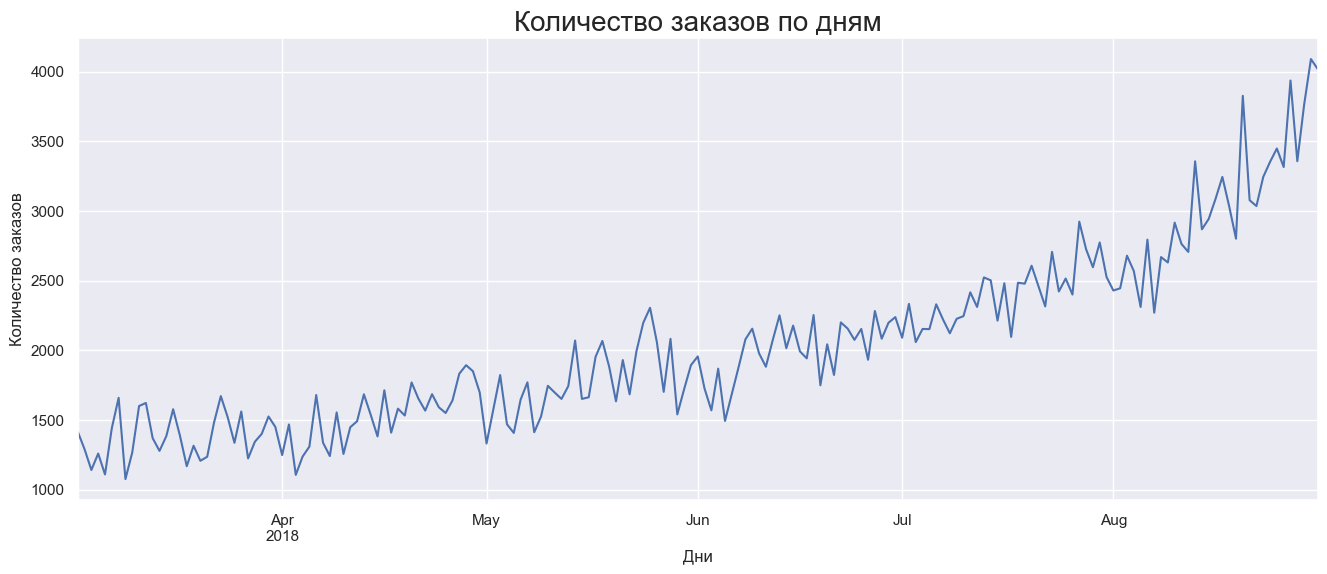

In [26]:
plt.figure(figsize=(16,6))
df.resample('1D')['num_orders'].sum().plot()
plt.ylabel('Количество заказов')
plt.xlabel('Дни')
plt.title('Количество заказов по дням', size=20);

На графике по дням слишком большой разброс, посмотрим график вызовов такси по месяцам

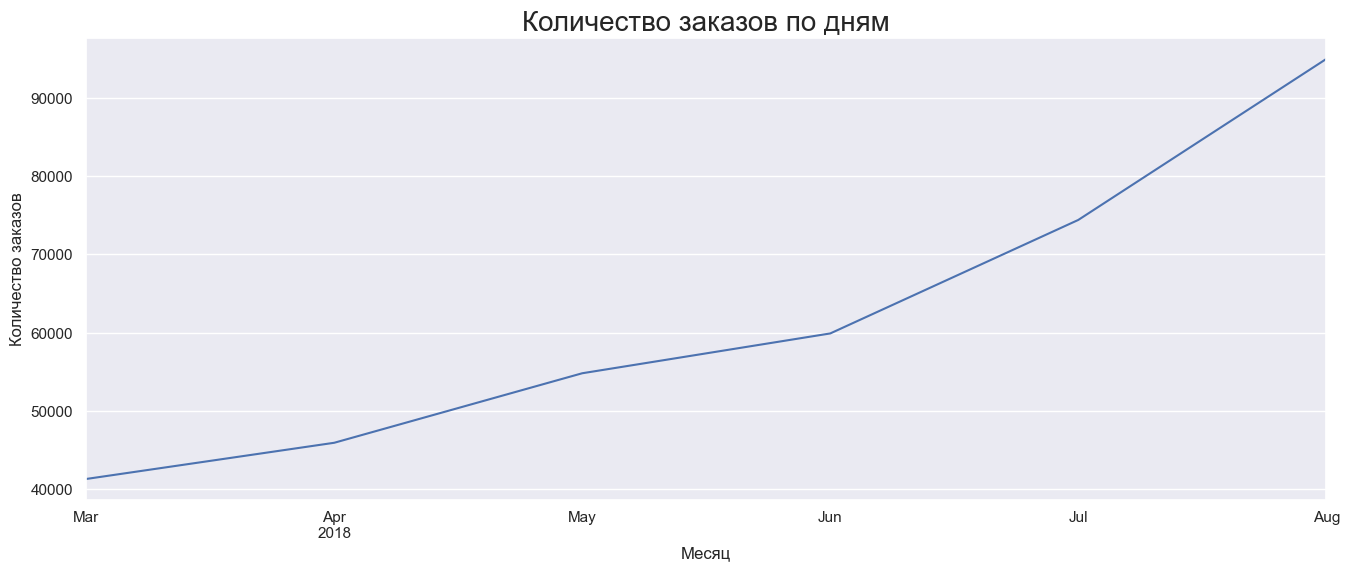

In [27]:
plt.figure(figsize=(16,6))
df.resample('1M')['num_orders'].sum().plot()
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов по дням', size=20);

Можем заметить что количество заказов такси каждый месяц только растет, а за 5 месяцев количество заказов выросло в 2 раза 

Проведем анализ временных рядов за первую неделю мая

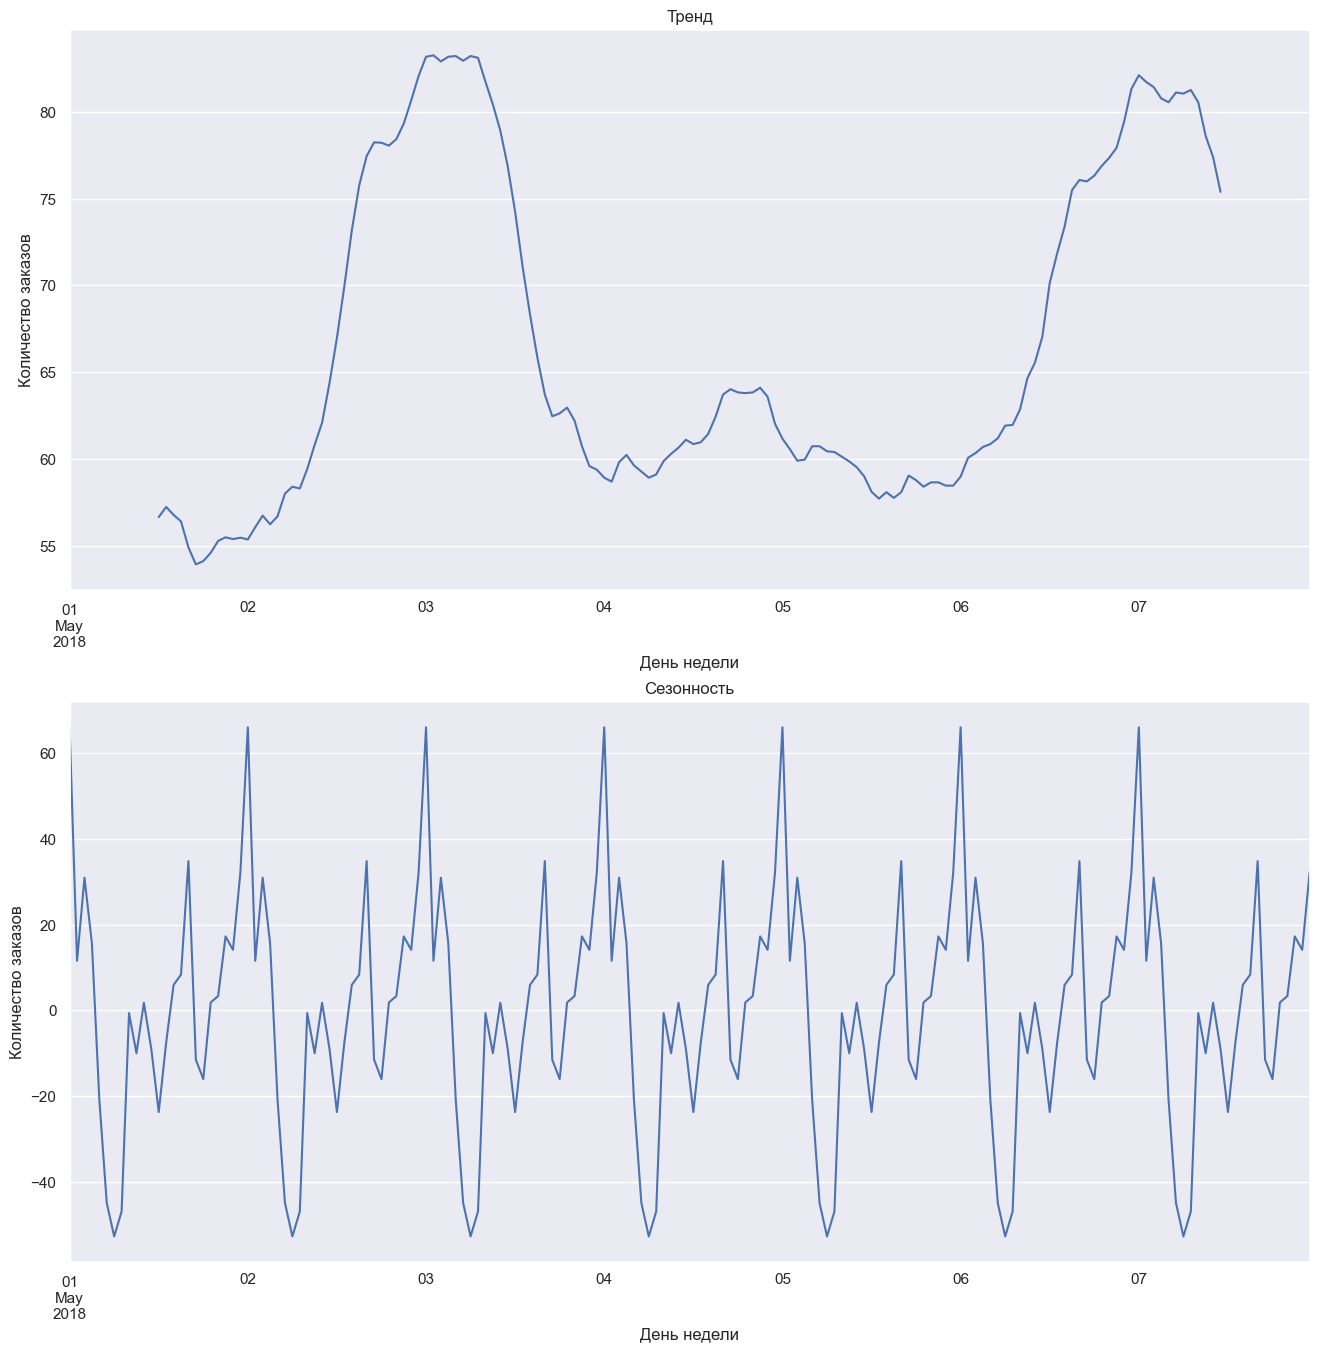

In [28]:
decomposed = seasonal_decompose(df.loc['2018-05-01':'2018-05-07','num_orders'])

fig, ax = plt.subplots(2,1, figsize=(16,16))
decomposed.trend.plot(ax=ax[0])
ax[0].set_title('Тренд')
ax[0].set_ylabel('Количество заказов')
ax[0].set_xlabel('День недели')

decomposed.seasonal.plot(ax=ax[1])
ax[1].set_title('Сезонность')
ax[1].set_ylabel('Количество заказов')
ax[1].set_xlabel('День недели');

### Вывод по анализу данных
* Количество заказов такси каждый постоянно растет, а за 5 месяцев количество заказов выросло в 2 раза, что может говорить что фирма развивается и у нее появляются новые клиенты
* Есть суточная сезонность. Ночью количество заказов близко к нулю, а утром, в обед и вечером достигаются локальные максимумы дня

## Подготовка данных

Разделим данные на целевой признак и признаки

In [29]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

Разделим данные на обучающую и тестовую выборку

In [30]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.2)

Проверим количество данны в ваборках

In [31]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, shuffle=False, test_size=0.5)

In [32]:
print('features_train:',features_train.shape[0])
print('target_train:',target_train.shape[0])
print()
print('features_valid:',features_valid.shape[0])
print('target_valid:',target_valid.shape[0])
print()
print('features_test:',features_test.shape[0])
print('target_test:',target_test.shape[0])

features_train: 3512
target_train: 3512

features_valid: 439
target_valid: 439

features_test: 440
target_test: 440


In [33]:
tscv = TimeSeriesSplit(n_splits=3)

### Напишем функцию RMSE:

In [34]:
def RMSE(predict, target):
    return (mean_squared_error(predict, target)) ** 0.5
rmse_score = make_scorer(RMSE, greater_is_better=False)

### Вывод по подготовке данных:
* Разбили данные на признаки и целевой признак
* Разделили данные на обучающую, тестовые и валидационную выборки
* Написали функцию RMSE

## Обучение моделей

### Модель LinearRegression

обучим модель LinearRegression из библиотеки sklearn

In [35]:
pipeline_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

Обучим модель

In [36]:
%%time
pipeline_lin.fit(features_train, target_train)

CPU times: user 12.2 ms, sys: 4.32 ms, total: 16.5 ms
Wall time: 12.4 ms


Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

Получим предсказания нашей модели и посмотрим RMSE

In [37]:
%%time
predict = pipeline_lin.predict(features_valid)

CPU times: user 9.3 ms, sys: 6.94 ms, total: 16.2 ms
Wall time: 5.78 ms


Посмотрим на RMSE

In [38]:
RMSE(predict, target_valid)

34.293707878441396

Создадим таблицу в которые будем заносить модели

In [39]:
df_total = pd.DataFrame.from_dict({'Модель': ['LinearRegression'],
                         'Время предсказания': [0.016],
                         'RMSE': [34.29]})

### Модель DecisionTreeRegressor

Найдем лучшие параметры с помощью GridSearchCV

In [40]:
%%time
params = {
    'max_depth':np.arange(5,11,1),
    'min_samples_split':np.arange(2,6,1),
    'min_samples_leaf':np.arange(1,10,1)
}
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

gscv_tree = GridSearchCV(model_tree, params, verbose=False, scoring=rmse_score, cv=tscv)
gscv_tree.fit(features_train, target_train)

print('Лучшее значение метрики:', -1*round(gscv_tree.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
gscv_tree.best_params_

Лучшее значение метрики: 29.083 

Подобранные гиперпараметры модели
CPU times: user 12.1 s, sys: 45.8 ms, total: 12.2 s
Wall time: 12.2 s


{'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}

Инициалицируем лучшую модель на кросс-валидации 

In [41]:
model_tree = gscv_tree.best_estimator_

Сделаем предсказания на валидационной выборке

In [42]:
%%time
predict = model_tree.predict(features_valid)

CPU times: user 2.08 ms, sys: 457 µs, total: 2.53 ms
Wall time: 2.26 ms


Посмотрим на RMSE

In [43]:
RMSE(predict, target_valid)

41.06630860715705

In [44]:
df_total.loc[1] = ['DecisionTreeRegressor',
                         0.003,
                         41.07]
df_total

,Модель,Время предсказания,RMSE
0,LinearRegression,0.016,34.29
1,DecisionTreeRegressor,0.003,41.07


### Модель RandomForestRegressor¶

Найдем лучшие параметры для модели случайного леса c помощью кросс-валидации

In [46]:
%%time
params = {
    'n_estimators':[100,200,300],
    'max_depth':np.arange(10,14,1),
    'min_samples_split':np.arange(2,5,1),
    'min_samples_leaf':np.arange(1,3,1)
         }
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

gscv_forest = GridSearchCV(model_forest, params, verbose=False, scoring=rmse_score, cv=tscv)
gscv_forest.fit(features_train, target_train)

print('Лучшее значение метрики:', -1*round(gscv_forest.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
gscv_forest.best_params_

Лучшее значение метрики: 25.194 

Подобранные гиперпараметры модели
CPU times: user 10min 18s, sys: 2.18 s, total: 10min 20s
Wall time: 10min 22s


{'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Инициализируем лучшую модель на кросс-валидации

In [47]:
model_forest = gscv_forest.best_estimator_

Сделаем предсказания на валидационной выборке

In [48]:
%%time
predtict = model_forest.predict(features_valid)

CPU times: user 27.1 ms, sys: 2.21 ms, total: 29.3 ms
Wall time: 27.7 ms


Посмотрим на RMSE

In [49]:
RMSE(predict, target_valid)

41.06630860715705

Занесем полученные данные в таблицу

In [50]:
df_total.loc[2] = ['RandomForestRegressor',
                         0.029,
                         41.07]
df_total

,Модель,Время предсказания,RMSE
0,LinearRegression,0.016,34.29
1,DecisionTreeRegressor,0.003,41.07
2,RandomForestRegressor,0.029,41.07


### Модель CatBoostRegressor

Найдем параметры которые будет подбирать GridSearchCV

In [51]:
%%time
params = [{
          'learning_rate': [0.01, 0.025, 0.05],
          'depth': [3, 5, 7, 9]
         }]
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

gscv_cbr = GridSearchCV(model_cbr, params, verbose=False, scoring=rmse_score, cv=tscv)
gscv_cbr.fit(features_train, target_train)

print('Лучшее значение метрики:', -round(gscv_cbr.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
gscv_cbr.best_params_

Лучшее значение метрики: 24.364 

Подобранные гиперпараметры модели
CPU times: user 8min 38s, sys: 24.9 s, total: 9min 3s
Wall time: 1min 35s


{'depth': 7, 'learning_rate': 0.025}

Создадим лучшую на GridSearchCV модель 

In [52]:
model_cbr = gscv_cbr.best_estimator_

Сделаем предсказания на тестовой выборке

In [53]:
%%time
predict = model_cbr.predict(features_valid)

CPU times: user 3.73 ms, sys: 1.51 ms, total: 5.24 ms
Wall time: 2.33 ms


Подсчитаем RMSE

In [54]:
RMSE(predict, target_valid)

32.068574666664595

Занесем данные в таблицу

In [55]:
df_total.loc[3] = ['CatBoostRegressor',
                         0.005,
                         32.07]
df_total

,Модель,Время предсказания,RMSE
0,LinearRegression,0.016,34.29
1,DecisionTreeRegressor,0.003,41.07
2,RandomForestRegressor,0.029,41.07
3,CatBoostRegressor,0.005,32.07


### Модель LGBMRegressor

Найдем лучшие параметры с помощью кросс-валидации

In [56]:
%%time
params = {
      'reg__learning_rate': [1, 0.1, 0.01],
      'reg__n_estimators': [100, 300, 500],
      'reg__max_depth': [4, 6, 8, 10],
      'reg__min_child_samples': [1, 5, 10]
  }
model_lgbmr = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
pipeline_lgbmr = Pipeline([('reg', model_lgbmr)])

gscv_lgbmr = GridSearchCV(pipeline_lgbmr, params, verbose=True, scoring=rmse_score, cv=tscv)
gscv_lgbmr.fit(features_train, target_train)

print('Лучшее значение метрики:', -round(gscv_lgbmr.best_score_, 3),'\n')
print('Подобранные гиперпараметры модели')
gscv_lgbmr.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Лучшее значение метрики: 24.725 

Подобранные гиперпараметры модели
CPU times: user 37min 45s, sys: 1min 23s, total: 39min 8s
Wall time: 6min 53s


{'reg__learning_rate': 0.1,
 'reg__max_depth': 6,
 'reg__min_child_samples': 1,
 'reg__n_estimators': 500}

Инициализируем лучшую модель на валидационной выборке

In [57]:
model_lgbmr = gscv_lgbmr.best_estimator_

Найдем предсказания модели

In [58]:
%%time
predict = model_lgbmr.predict(features_valid)

CPU times: user 3.33 ms, sys: 1.62 ms, total: 4.96 ms
Wall time: 2.27 ms


Посмотрим какой RMSE получился у нашей модели

In [59]:
RMSE(predict, target_valid)

32.29446471134928

Занесем данные в таблицу

In [60]:
df_total.loc[4] = (['LGBMRegressor',
                         0.005,
                         32.29])
df_total

,Модель,Время предсказания,RMSE
0,LinearRegression,0.016,34.29
1,DecisionTreeRegressor,0.003,41.07
2,RandomForestRegressor,0.029,41.07
3,CatBoostRegressor,0.005,32.07
4,LGBMRegressor,0.005,32.29


Так как RMSE всех моделей на валидационных данных удовлетворяет условию RMSE < 48, и разница между моделями не особо большая, возьмем Модель CatBoostRegressor, она не такая быстрая как другие модель за то намного проще в обучении 

## Анализ лучшей модели

Инициализируем лучшую модель

In [61]:
best_model = model_cbr

Дополним обучающую выборку валидационной

In [62]:
features_train = pd.concat([features_train,features_valid], ignore_index=True)
target_train = pd.concat([target_train, target_valid], ignore_index=True)

Обучим нашу лучшую модель на обновленных тренировочных данных 

In [63]:
best_model.fit(features_train, target_train);

Сделаем предсказания на тестовой выборке

In [65]:
%%time
predict = model_cbr.predict(features_test)

CPU times: user 5.67 ms, sys: 3.77 ms, total: 9.44 ms
Wall time: 5.62 ms


Посмотрим на RMSE

In [66]:
RMSE(predict, target_test)

41.36808650216473

RMSE удовлетворяет нашему условию RMSE=41.37

## Вывод:
* Знакомство с данными
    * Загрузили и сохранили данные в датафрейм **df**
    * Проблем в данных не было обнаружено
    * Целевая переменная принимает распределение Пуассона, что ей должно быть и свойственно 
* Предобработка
    * Изменили типы данных
        * **datetime** object -> datetime
        * **num_orders** int64 -> uint16
    * Индексами нашего датафрейма стал столбец **datetime**
    * Проресемплировали данные по одному часу
    * Создали новые столбцы:
        * **year** - год заказа
        * **month** - месяц заказа
        * **day** - день заказа
        * **day_of_week** - день недели заказа
        * **lag_N** - данные за N дней назад
        * **rolling_mean** - Скользящее среднее за 5 дней
    * Выбросы были только в целевом признаки, но было принято решение не удалять данные
* Анализ данных
    * Количество заказов такси каждый постоянно растет, а за 5 месяцев количество заказов выросло в 2 раза, что может говорить что фирма развивается и у нее появляются новые клиенты
    * Есть суточная сезонность. Ночью количество заказов близко к нулю, а утром, в обед и вечером достигаются локальные максимумы дня
* подготовка данных
    * Разбили данные на признаки и целевой признак
    * Разделили данные на обучающую, тестовые и валидационную выборки
    * Написали функцию RMSE
* Обучение моделей
    * Мы нашли лучшие параметры и обучили 3 модели:
        * LinearRegression
        * CatBoostRegressor
        * LGBMRegressor
    * RMSE всех моделей на валидационных данных удовлетворяло условию RMSE < 48, а разница между моделями не особо большая, возьмем Модель CatBoostRegressor, она не такая быстрая в предсказании как другие модель за то намного проще в обучении. Мы обучили модель CatBoostRegressor на тестовой выборке и получили такие результаты
        * Время предсказания: 9 ms
        * RMSE: 41.37